In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from corner import corner
from acor import acor
from utils.UL_uncert import UL_uncert

from matplotlib.colors import LogNorm

%matplotlib inline

def trace_plot(chain, pars,
               cols=3, wid_per_col=4, aspect=4/3,
               kwargs={}):

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].plot(chain[:,pp], **kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig


def hist_plot(chain, pars, bins=30,
              cols=3, wid_per_col=4, aspect=4/3,
              kwargs={}):
    hist_kwargs = {
        'density':True,
        'histtype':'step',
    }
    for key, val in kwargs.items():
        hist_kwargs[key] = val

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].hist(chain[:,pp], bins=bins, **hist_kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig

def bayes_fac(samples, Nmin=200, logAmin=-18, logAmax=-9,
              dAmin=0.01, dAmax=0.5):
    """
    Computes the Savage Dickey Bayes Factor and uncertainty.

    :param samples: MCMC samples of GWB (or common red noise) amplitude
    :param ntol: Tolerance on number of samples in bin

    :returns: (bayes factor, 1-sigma bayes factor uncertainty)
    """

    prior = 1 / (logAmax - logAmin)
    dA = np.linspace(dAmin, dAmax, 100)
    bf = []
    bf_err = []
    mask = [] # selecting bins with more than 200 samples

    for ii, delta in enumerate(dA):
        n = np.sum(samples <= (logAmin + delta))
        N = len(samples)

        post = n / N / delta

        bf.append(prior/post)
        bf_err.append(bf[ii]/np.sqrt(n))

        if n > Nmin:
            mask.append(ii)

    return np.mean(np.array(bf)[mask]), np.std(np.array(bf)[mask])

In [2]:
TMIN = 53217.0
TMAX = 57387.0
tchunk = np.linspace(TMIN, TMAX, 41)  # break in 2.5% chunks
tlim = []
for ii in range(len(tchunk)-2):
    tlim.append(tchunk[ii:ii+3])

In [3]:
psrlist = '/home/pbaker/nanograv/data/nano11/11yr_34.txt'
with open(psrlist, 'r') as f:
    all_psrs = [line.strip() for line in f]
all_psrs.sort()

# detection runs

## try out a particular pulsar

In [ ]:
# the three w/ BF > 1
psr = 'J1744-1134'
#psr = 'J1747-4036'
#psr = 'J1909-3744'

ephem = 'DE436'

rundir = '/home/pbaker/nanograv/bwm/sngl/detect_{0:s}/{1:s}/'.format(ephem, psr)

In [ ]:
with open(rundir + 'params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_bwm = []
for par in params:
    if par.startswith('bwm_'):
        par_bwm.append(par)
idx_bwm = [params.index(p) for p in par_bwm]
idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')

In [ ]:
chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                        sep='\t', dtype=float, header=None).values

In [ ]:
burnfrac = 0.10
thin = 20

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

chain_bwm = chain[:,idx_bwm]
chain_L = chain[:,-4]

corL = acor(chain_L)[0]
N = len(chain_bwm)
print("N = {}, corL = {}".format(N, corL))

In [ ]:
ch_plt = np.hstack([chain_bwm, chain_L.reshape(N,1)])
par_plt = par_bwm + ['logL']

trace_plot(ch_plt, par_plt, cols=3, wid_per_col=4);

In [ ]:
fig = hist_plot(ch_plt, par_plt, cols=3, wid_per_col=4)
for ax in fig.axes:
    ax.set_yscale('log')

In [ ]:
from astropy.time import Time

lognorm = LogNorm()
Tmin, Tmax = Time([TMIN,TMAX], format='mjd').decimalyear

hist_kwargs = {'bins':30,
               'normed':True,
               'cmap':'Blues',
               #'vmin':1.0e5,
               #'vmax':1.0e10,
               'norm':lognorm,
                }

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

t_ch = Time(chain_bwm[:,idx_t0], format='mjd').decimalyear
logA_ch = chain_bwm[:,idx_A]
A_ch = 10**logA_ch
    
ax.hist2d(t_ch, logA_ch, **hist_kwargs)

#if ii_t:
#    ax.axvline(x=tmin, color='k', linestyle=':')
#    ax.axvline(x=tmax, color='k', linestyle=':')

ax.set_xlabel(r'$t_0$ (MJD)')
ax.set_ylabel(r'$\log_{10}(A_{BWM})$')
ax.set_ylim([-18,-9])
ax.set_xlim([Tmin, Tmax])
#ax.set_title('{:.1f} yr timeslice (w/ dropout)'.format(slice_yr))

In [ ]:
BF, dBF = bayes_fac(chain_bwm[:,idx_A], Nmin=50)

In [ ]:
corner_kwargs = {'bins':30,
                 'show_titles':True,
                 'labels':par_bwm,
                 'smooth':0.5,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(chain_bwm, color='C0', **corner_kwargs);
fig.suptitle("{:s} -- BF = {:.3f}".format(psr, BF), fontsize=20);

## t-posterior for all BF > 1

In [ ]:
# the three w/ BF > 1
PSRs = ['J1744-1134',
        'J1747-4036',
        'J1909-3744']
ephem = 'DE436'
burnfrac = 0.10
thin = 200

ch_dict = {}
for psr in PSRs:
    rundir = '/home/pbaker/nanograv/bwm/sngl/detect_{0:s}/{1:s}/'.format(ephem, psr)
    
    # get t0 index
    with open(rundir + 'params.txt', 'r') as f:
        params = [line.rstrip('\n') for line in f]
    idx_t0 = params.index('bwm_t0')
    
    chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                        sep='\t', dtype=float, header=None).values
    burn = int(burnfrac * len(chain_raw))
    ch_t = Time(chain_raw[burn::thin, idx_t0], format='mjd').decimalyear

    N = len(ch_t)
    corL = acor(chain_raw[:,-5])[0]
    print("{} -- N = {}, corL = {}".format(psr, N, corL))
    ch_dict[psr] = ch_t

In [ ]:
Tmin = np.min([ch.min() for ch in ch_dict.values()])
Tmax = np.max([ch.max() for ch in ch_dict.values()])
myBins = np.linspace(Tmin, Tmax, 41)

In [ ]:
for psr, ch in ch_dict.items():
    plt.hist(ch, bins=myBins, density=True, histtype='step', label=psr)
plt.yscale('log')
plt.legend()

In [ ]:
rundir = '/home/pbaker/nanograv/bwm/allsky/DE436_BE/detection/'
burnfrac = 0.10
thin = 50

# get t0 index
with open(rundir + 'params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]
idx_t0 = params.index('bwm_t0')

chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                        sep='\t', dtype=float, header=None).values
burn = int(burnfrac * len(chain_raw))
ch11_t = Time(chain_raw[burn::thin, idx_t0], format='mjd').decimalyear

N = len(ch_t)
corL = acor(chain_raw[:,-5])[0]
print("{} -- N = {}, corL = {}".format(psr, N, corL))

In [ ]:
for psr, ch in ch_dict.items():
    plt.hist(ch, bins=myBins, density=True, histtype='step', label=psr)

plt.hist(ch11_t, bins=myBins, density=True, histtype='step', color='k', label="Earth term")
plt.yscale('log')
plt.legend()

In [ ]:
np.histogram(ch11_t, bins=myBins, density=True)

## compute BF for all pulsar terms!

In [4]:
runroot = '/home/pbaker/nanograv/bwm/sngl/detect_DE436'
bf_dict = {}

burnfrac = 0.10
thin = 20

ii_A = 2

In [5]:
for psr in all_psrs:
    rundir = os.path.join(runroot, psr)
    chain_raw = pd.read_csv(rundir + '/chain_1.txt',
                            sep='\t', dtype=float, header=None).values

    burn = int(burnfrac * len(chain_raw))
    chain = chain_raw[burn::thin]

    ch_A = chain[:, ii_A]

    corA = acor(ch_A)[0]
    N = len(ch_A)
    BF = bayes_fac(ch_A)
    print(psr)
    print("  N = {}, corL = {}".format(N, corA))
    print("  BF = {:.4f} +/- {:.4f}".format(*BF))
    bf_dict[psr] = BF[0]

B1855+09
  N = 145265, corL = 1.234061554087512
  BF = 0.6479 +/- 0.0065
B1937+21
  N = 30411, corL = 1.0407255800063266
  BF = 0.6132 +/- 0.0078
B1953+29
  N = 12047, corL = 0.921886947543087
  BF = 0.6322 +/- 0.0156
J0023+0923
  N = 130734, corL = 1.000024748241849
  BF = 0.5663 +/- 0.0076
J0030+0451
  N = 38687, corL = 0.9955248273008679
  BF = 0.6190 +/- 0.0128
J0340+4130
  N = 14985, corL = 0.9777744258687306
  BF = 0.5875 +/- 0.0231
J0613-0200
  N = 105642, corL = 1.2162444164336867
  BF = 0.7169 +/- 0.0143
J0645+5158
  N = 12249, corL = 0.9715817364030425
  BF = 0.5210 +/- 0.0057
J1012+5307
  N = 81059, corL = 1.394133440802989
  BF = 0.9061 +/- 0.0268
J1024-0719
  N = 18572, corL = 1.0172178720565614
  BF = 0.6341 +/- 0.0070
J1455-3330
  N = 12794, corL = 0.9877304021433615
  BF = 0.5948 +/- 0.0194
J1600-3053
  N = 34916, corL = 1.0144482248894084
  BF = 0.4638 +/- 0.0065
J1614-2230
  N = 12537, corL = 0.9812081360998155
  BF = 0.4622 +/- 0.0097
J1640+2224
  N = 25862, corL = 0

In [6]:
import json

out = os.path.join(runroot, "sngl_BF.json")
with open(out, 'w') as f:
    json.dump(bf_dict, f)

In [7]:
[(k,v) for k,v in bf_dict.items() if v>1]

[('J1744-1134', 3.585390803085768),
 ('J1747-4036', 1.6495632521986918),
 ('J1909-3744', 1.3798393553723767)]

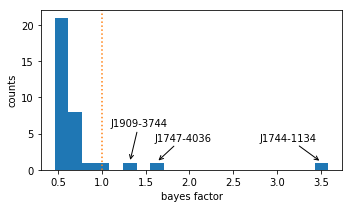

In [8]:
ar_kwargs = {'arrowstyle':'->'}

bfs = [x for x in bf_dict.values()]
plt.figure(figsize=(5,3))

plt.hist(bfs, bins=20);
plt.xlabel('bayes factor')
plt.ylabel('counts')
plt.axvline(x=1, ls=':', color='C1')

psrs = ['J1909-3744', 'J1747-4036', 'J1744-1134']
arrow_loc = [(1.32, 1.1), (1.63, 1.1), (3.50, 1.1)]
text_loc = [(1.1, 6), (1.6, 4), (2.8, 4)]

#psrs = ['J1747-4036 and J1909-3744', 'J1744-1134']
#arrow_loc = [(1.60, 2), (3.05, 1)]
#text_loc = [(1.2, 4),
#            (2.5, 3)]
for p, xy, xytext in zip(psrs, arrow_loc, text_loc):
    plt.annotate(p, xy, xytext, arrowprops=ar_kwargs)

plt.tight_layout()
plt.savefig('/home/pbaker/psrTerm_BF.pdf')

In [ ]:
this_bf = bf_dict['J1744-1134']
this_prob = 1/(1+1/this_bf)
print("BF = {:.3f},  prob = {:.3f}".format(this_bf, this_prob))

# ULs

In [ ]:
all_psrs[18]

`ii_t = 20` is nearly centered on the anomally

* 4 $\rightarrow$ J0030+0451
* 15 $\rightarrow$ J1713+0747
* 22 $\rightarrow$ J1909-3744

In [ ]:
psr = all_psrs[18]
ephem = 'DE436'

ii_t = 20  # 0-40 or None
if ii_t:
    tmin, cent, tmax = tlim[ii_t]
    chunk = '{:.2f}'.format(cent)
else:
    chunk = 'all'

rundir = '/home/pbaker/nanograv/bwm/sngl/uplim_{0:s}/{1:s}/{2:s}/'.format(ephem, psr, chunk)

In [ ]:
with open(rundir + 'params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_bwm = []
for par in params:
    if par.startswith('bwm_'):
        par_bwm.append(par)
idx_bwm = [params.index(p) for p in par_bwm]
idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')

In [ ]:
chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                        sep='\t', dtype=float, header=None).values

In [ ]:
burnfrac = 0.10
thin = 20

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

chain_bwm = chain[:,idx_bwm]
chain_L = chain[:,-4]

corL = acor(chain_L)[0]
N = len(chain_bwm)
print("N = {}, corL = {}".format(N, corL))

In [ ]:
ch_plt = np.hstack([chain_bwm, chain_L.reshape(N,1)])
par_plt = par_bwm + ['logL']
trace_plot(ch_plt, par_plt, cols=3, wid_per_col=4);

In [ ]:
fig = hist_plot(ch_plt, par_plt, cols=3, wid_per_col=4)
for ax in fig.axes:
    ax.set_yscale('log')

In [ ]:
corner_kwargs = {'bins':30,
                 'show_titles':True,
                 'labels':par_bwm,
                 'smooth':0.5,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(chain_bwm, color='C0', **corner_kwargs);
fig.suptitle(psr);

In [ ]:
np.median(10**chain_bwm[:,idx_A])

In [ ]:
plt.hist(10**chain_bwm[:, idx_A], bins=50, density=True);
plt.yscale('log')

In [ ]:
UL_uncert(10**chain_bwm[:, idx_A])

In [ ]:
from astropy.time import Time

lognorm = LogNorm()
Tmin, Tmax = Time([TMIN,TMAX], format='mjd').decimalyear

hist_kwargs2D = {
    'bins':30,
    'normed':True,
    'cmap':'Blues',
    'norm':lognorm,
}
hist_kwargs = {
    'bins':30,
    'density':True,
    'histtype':'step',
}


tbox = [0.15, 0.65, 0.80, 0.30]
bbox = [0.15, 0.15, 0.80, 0.50]

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes(bbox)
ax2 = fig.add_axes(tbox)

t_ch = Time(chain_bwm[:,idx_t0], format='mjd').decimalyear
logA_ch = chain_bwm[:,idx_A]
A_ch = 10**logA_ch
    
ax1.hist2d(t_ch, logA_ch, **hist_kwargs2D)
ax2.hist(t_ch, **hist_kwargs)

#if ii_t:
#    ax.axvline(x=tmin, color='k', linestyle=':')
#    ax.axvline(x=tmax, color='k', linestyle=':')

ax1.set_xlabel(r'$t_0$ (MJD)')
ax1.set_ylabel(r'$\log_{10}(A_{BWM})$')
ax1.set_ylim([-18,-9])
ax1.set_xlim([Tmin, Tmax])
ax2.set_xlim([Tmin, Tmax])
#ax.set_title('{:.1f} yr timeslice (w/ dropout)'.format(slice_yr))

In [ ]:
tbins = np.arange(2004, 2016, 0.5)

t_cent = []
UL_binned = []
A_ch_binned = []

for left, cent, right in tlim:
    left, cent, right = Time([left, cent, right], format='mjd').decimalyear
    
    mask = np.logical_and(t_ch>left, t_ch<right)
    if len(A_ch[mask]) > 0:
        t_cent.append(cent)
        A_ch_binned.append(A_ch[mask])
        UL_binned.append(np.percentile(A_ch[mask], 95))

In [ ]:
plt.plot(t_cent, UL_binned)
plt.yscale('log')

# loop over all pulsars

In [ ]:
runroot = '/home/pbaker/nanograv/bwm/sngl/uplim_DE436'

burnfrac = 0.10
thin = 20

ii_A = 2

UL_dict = {}  # keys->psrname, vals->(Ts, ULs, dULs)

In [ ]:
for psr in all_psrs:
    Ts = []
    ULs = []
    dULs = []
    print(psr+"...")
    for chunk in tlim:
        this_T = chunk[1]
        try:
            rundir = os.path.join(runroot, psr, '{:.2f}'.format(this_T))
            chain_raw = pd.read_csv(rundir + '/chain_1.txt',
                        sep='\t', dtype=float, header=None).values

            burn = int(burnfrac * len(chain_raw))
            ch_A = 10**chain_raw[burn::thin, ii_A]
            this_UL, this_dUL = UL_uncert(ch_A)
            print("  {:.2f} -- {:.3e} +/- {:.2e} (N = {:d})".format(this_T, this_UL, this_dUL, len(ch_A)))

            Ts.append(this_T)
            ULs.append(this_UL)
            dULs.append(this_dUL)
        except IOError:
            print("  {:.2f} -- no data".format(this_T))
    
    UL_dict[psr] = (Ts, ULs, dULs)
    
    outdir = os.path.join(runroot, psr)
    np.savetxt(outdir + "/ULvT_{:s}.dat".format(psr), UL_dict[psr])
    print("          ...done.")

In [ ]:
test_psrs = ['J1012+5307',
             'J1713+0747',
             #'J1744-1134',
             'J1909-3744',
             #'J2145-0750',
             'J2317+1439'
             ]

for psr in test_psrs:
    ts, ULs, dULs = UL_dict[psr]
    plt.errorbar(*UL_dict[psr], label=psr)

plt.legend()
plt.yscale('log')
plt.ylim([4e-15,4e-13])    

In [ ]:
#psr = 'J1713+0747'
psr = 'J1909-3744'
ts, ULs, dULs = UL_dict[psr]

ts = Time(ts, format='mjd').decimalyear

plt.plot(ts, ULs, label='time binned runs')
plt.plot(t_cent, UL_binned, label='all time run')
plt.legend()
plt.yscale('log')

In [ ]:
for tt, uu in zip(np.array(tlim)[:,1], ULs['DE436_BE']):
    print("{:.2f}:    h_mem < {:.3e}".format(tt, uu))